# Notebook Pengolahan Data & Pelatihan Model (Decision Tree) — FlashKlik

## Perkenalan
- **Nama** : Moch. Yasin Abdillah
- **NIM** : 191011401421
- **Judul Skripsi**: IMPLEMENTASI DATA MINING UNTUK MENGANALISIS DAN MEMPREDIKSI KERUSAKAN PERANGKAT ELEKTRONIK DI FLASHKLIK MENGGUNAKAN METODE CLASSIFICATION PADA PT. CONCORDIA SOLUTION INDONESIA 
- **Metode**: Metode Classification → **Decision Tree Classifier**
- **Output**: Model terlatih (`.joblib`) yang dapat dipanggil melalui API (FastAPI) untuk membantu teknisi saat melakukan diagnosa awal.

## Gambaran Dataset
Dataset yang digunakan berisi data ticket/keluhan perangkat dengan 5 kolom utama:
- `ttrcheck_description` : deskripsi hasil pengecekan oleh teknisi
- `ttcheck_remark_service` : deskripsi keluhan dari customer
- `ttcheck_device_service` : jenis perangkat (contoh: NB/PC/Printer)
- `ttcheck_brand_service` : merk perangkat
- `ttcheck_series_service` : series/tipe perangkat

### Catatan :
- NB : Notebook
- PC : PC/ DEKSTOP
- PT : Printer

## Objective
Membangun model klasifikasi yang dapat memprediksi **kategori kerusakan** berdasarkan keluhan (teks) dan informasi perangkat (device/brand/series).
Kategori dibentuk melalui *rule-based mapping* dari teks keluhan agar dataset memiliki label target untuk pembelajaran terawasi (*supervised learning*).

## 2. Import Libraries

In [1]:

import os
import re
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)

## 3. Data Loading & Data Preprocessing Awal

### 3.1 Load Dataset

In [2]:

# Otomatis pakai dataset_baru_updated.csv kalau ada, jika tidak ada pakai dataset_baru.csv
if os.path.exists("dataset.csv"):
    DATASET_PATH = "dataset.csv"
else:
    DATASET_PATH = "dataset.csv"

df = pd.read_csv(DATASET_PATH)
print("Dataset:", DATASET_PATH)
print("Shape awal (baris, kolom):", df.shape)
display(df.head())

Dataset: dataset.csv
Shape awal (baris, kolom): (315, 5)


,ttrcheck_description,ttcheck_remark_service,ttcheck_device_service,ttcheck_brand_service,ttcheck_series_service
0,"Kabel power monitor longgar/adaptor rusak, gan...",Monitor mati total tidak ada lampu,PC,Dell,OptiPlex 5070
1,Printer epson L3210 Sn.XAGK164302 kendala prin...,Rusak Ink pad nya tidak jalan,PT,Epson l3210,L3210
2,engsel aus layar tidak stabil,engsel aus membuat layar mudah turun dan tidak...,NB,SAMSUNG,Galaxy Book
3,-Hp deskjet2135 sn:CN9BA483S5 error printing -...,Error printing,PT,HP,DeskJet 2135
4,Sudah dilakukan pergantian pasta unit tetap le...,setelah install ulang tidak mau diupdate firmw...,NB,lenovo,thinkpad x1 yoga


### 3.2 Cek Kolom & Tipe Data

In [3]:

print("Daftar kolom:", df.columns.tolist())
print("\nInfo dataset:")
df.info()

Daftar kolom: ['ttrcheck_description', 'ttcheck_remark_service', 'ttcheck_device_service', 'ttcheck_brand_service', 'ttcheck_series_service']

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ttrcheck_description    315 non-null    object
 1   ttcheck_remark_service  315 non-null    object
 2   ttcheck_device_service  315 non-null    object
 3   ttcheck_brand_service   315 non-null    object
 4   ttcheck_series_service  315 non-null    object
dtypes: object(5)
memory usage: 12.4+ KB


### 3.3 Cek Missing Value

In [4]:

    print("Missing value per kolom:")
    display(df.isna().sum())

    print("\nTotal baris yang punya missing value (minimal 1 kolom kosong):")
    print(df.isna().any(axis=1).sum())

Missing value per kolom:


ttrcheck_description      0
ttcheck_remark_service    0
ttcheck_device_service    0
ttcheck_brand_service     0
ttcheck_series_service    0
dtype: int64


Total baris yang punya missing value (minimal 1 kolom kosong):
0


### 3.4 Hapus Baris yang Memiliki Missing Value (dropna)

In [5]:

shape_before = df.shape
df = df.dropna().reset_index(drop=True)
shape_after = df.shape

print("Shape sebelum dropna:", shape_before)
print("Shape sesudah dropna :", shape_after)
print("Baris terhapus       :", shape_before[0] - shape_after[0])

Shape sebelum dropna: (315, 5)
Shape sesudah dropna : (315, 5)
Baris terhapus       : 0


### 3.5 Cek Duplikat

In [6]:

dup_count = df.duplicated().sum()
print("Jumlah duplikat baris:", dup_count)

if dup_count > 0:
    print("\nContoh duplikat (5 baris pertama):")
    display(df[df.duplicated(keep=False)].head())

Jumlah duplikat baris: 5

Contoh duplikat (5 baris pertama):


,ttrcheck_description,ttcheck_remark_service,ttcheck_device_service,ttcheck_brand_service,ttcheck_series_service
26,unit tidak bisa power on,tidak ada respon saat tombol power ditekan,PC,ASUS,ExpertCenter
61,PC hidup tapi tidak muncul display,indikator power on namun monitor tidak menampi...,PC,Lenovo,ThinkCentre
92,PC mati total tidak dapat dinyalakan,indikator tidak menyala dan unit tidak power up,PC,Dell,Precision
93,PC mati total tidak dapat dinyalakan,indikator tidak menyala dan unit tidak power up,PC,Dell,Precision
111,unit tidak bisa power on,tidak ada respon saat tombol power ditekan,PC,ASUS,ExpertCenter


### 3.6 Hapus Duplikat

In [7]:

shape_before = df.shape
df = df.drop_duplicates().reset_index(drop=True)
shape_after = df.shape

print("Shape sebelum drop_duplicates:", shape_before)
print("Shape sesudah drop_duplicates :", shape_after)
print("Baris terhapus                :", shape_before[0] - shape_after[0])

Shape sebelum drop_duplicates: (315, 5)
Shape sesudah drop_duplicates : (310, 5)
Baris terhapus                : 5


### 3.7 Dropna Lagi (setelah penghapusan duplikat)

In [8]:

shape_before = df.shape
df = df.dropna().reset_index(drop=True)
shape_after = df.shape

print("Shape sebelum dropna (ulang):", shape_before)
print("Shape sesudah dropna (ulang) :", shape_after)
print("Baris terhapus               :", shape_before[0] - shape_after[0])

Shape sebelum dropna (ulang): (310, 5)
Shape sesudah dropna (ulang) : (310, 5)
Baris terhapus               : 0


### 3.8 Hapus Data Dummy

In [9]:

dummy_mask = (
    df["ttcheck_remark_service"].astype(str).str.contains("dummy", case=False, na=False) |
    df["ttrcheck_description"].astype(str).str.contains("dummy", case=False, na=False)
)

print("Jumlah baris dummy terdeteksi:", dummy_mask.sum())

shape_before = df.shape
df = df.loc[~dummy_mask].reset_index(drop=True)
shape_after = df.shape

print("Shape sebelum hapus dummy:", shape_before)
print("Shape sesudah hapus dummy :", shape_after)
print("Baris terhapus            :", shape_before[0] - shape_after[0])

Jumlah baris dummy terdeteksi: 25
Shape sebelum hapus dummy: (310, 5)
Shape sesudah hapus dummy : (285, 5)
Baris terhapus            : 25


### 3.9 Normalisasi Device (gabung laptop/notebook → NB)

In [10]:

df["ttcheck_device_service"] = (
    df["ttcheck_device_service"].astype(str).str.strip().str.lower()
)

device_map = {
    "laptop": "nb",
    "notebook": "nb",
    "notebook pc": "nb",
    "nb": "nb",
    "pc": "pc",
    "pt": "pt",
    "printer": "pt",
}

df["ttcheck_device_service"] = df["ttcheck_device_service"].replace(device_map).str.upper()

print("Distribusi device setelah normalisasi:")
display(df["ttcheck_device_service"].value_counts())

Distribusi device setelah normalisasi:


ttcheck_device_service
NB    190
PC     73
PT     22
Name: count, dtype: int64

### 3.10 Cleaning Text & Normalisasi Kategori (brand/series)

In [11]:

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["ttcheck_remark_service"] = df["ttcheck_remark_service"].replace("Dummy Data", "", regex=False)

df["text_combined_raw"] = (
    df["ttrcheck_description"].astype(str) + " " + df["ttcheck_remark_service"].astype(str)
)

df["text_combined"] = df["text_combined_raw"].apply(clean_text)

# brand/series dibuat lowercase agar konsisten untuk OneHotEncoder
for col in ["ttcheck_brand_service", "ttcheck_series_service"]:
    df[col] = df[col].astype(str).str.lower().str.strip()

display(df[["text_combined", "ttcheck_device_service", "ttcheck_brand_service", "ttcheck_series_service"]].head())


,text_combined,ttcheck_device_service,ttcheck_brand_service,ttcheck_series_service
0,kabel power monitor longgar adaptor rusak gant...,PC,dell,optiplex 5070
1,printer epson l3210 sn xagk164302 kendala prin...,PT,epson l3210,l3210
2,engsel aus layar tidak stabil engsel aus membu...,NB,samsung,galaxy book
3,hp deskjet2135 sn cn9ba483s5 error printing di...,PT,hp,deskjet 2135
4,sudah dilakukan pergantian pasta unit tetap le...,NB,lenovo,thinkpad x1 yoga


### 3.11 Labeling Kategori Kerusakan (Rule-based Mapping)

In [12]:
motherboard_keywords = [
    "vrm", "mosfet", "jalur", "power rail", "short", "korslet", "konslet",
    "ic power", "ic pwm", "retimer", "chipset", "southbridge", "northbridge",
    "ec ic", "bios ic", "repair mainboard",
    "motherboard", "mainboard"
]

def has_any(text, keywords):
    return any(k in text for k in keywords)

def has_word(text, word):
    return re.search(rf"\b{re.escape(word)}\b", text) is not None

def map_kategori_v2(text: str) -> str:
    if not isinstance(text, str):
        return "LAINNYA"
    t = text.lower()

    # 1) PRINTER
    if has_any(t, ["printer", "paper jam", "cartridge", "tinta", "roller", "head"]):
        return "PRINTER"

    # 2) DISPLAY
    if has_any(t, ["lcd", "layar", "display", "blank", "bergaris", "flicker", "backlight", "no signal", "hdmi", "dp", "vga"]):
        return "DISPLAY"

    # 3) ENGSEL
    if has_any(t, ["engsel", "hinge", "bezel", "casing patah", "retak body"]):
        return "ENGSEL"

    # 4) KEYBOARD
    if has_any(t, ["keyboard", "tombol", "key", "numpad"]):
        return "KEYBOARD"

    # 5) TOUCHPAD
    if has_any(t, ["touchpad", "trackpad"]):
        return "TOUCHPAD"

    # 6) OVERHEAT
    if has_any(t, ["overheat", "panas", "kipas", "fan", "thermal", "throttling", "heatsink", "thermal paste", "repaste"]):
        return "OVERHEAT"

    # 7) STORAGE
    if has_any(t, ["ssd", "hdd", "harddisk", "bad sector", "smart", "no bootable device", "boot device", "m.2", "nvme", "sata"]):
        return "STORAGE"

    # 8) SOFTWARE
    if has_any(t, ["windows", "driver", "software", "install", "update", "bsod", "blue screen", "virus", "malware", "hang", "lemot", "freeze"]):
        return "SOFTWARE"

    # 9) BATTERY
    if has_any(t, ["battery", "baterai", "batre", "batt"]):
        return "BATTERY"

    # 10) POWER / CHARGING
    if has_any(t, ["tidak nyala", "mati total", "no power", "charger", "adaptor", "adapter", "dc jack", "charging", "cas", "power button"]):
        return "POWER"

    # 11) MOTHERBOARD (terakhir dan lebih spesifik)
    if has_any(t, motherboard_keywords) or has_word(t, "mb"):
        return "MOTHERBOARD"

    return "LAINNYA"


# Buat kolom target berdasarkan rule-based mapping
df["label_kategori"] = df["text_combined"].apply(map_kategori_v2)

print("Distribusi label (hasil mapping v2):")
display(df["label_kategori"].value_counts())

Distribusi label (hasil mapping v2):


label_kategori
DISPLAY        72
KEYBOARD       42
SOFTWARE       28
LAINNYA        26
BATTERY        25
STORAGE        23
OVERHEAT       22
PRINTER        22
POWER          14
ENGSEL          7
MOTHERBOARD     3
TOUCHPAD        1
Name: count, dtype: int64

### 3.12 Outlier Handling Berdasarkan Panjang Teks

In [13]:

df["text_len"] = df["text_combined"].str.len()

min_len = 10
max_len = int(df["text_len"].quantile(0.99))


shape_before = df.shape
df = df[(df["text_len"] >= min_len) & (df["text_len"] <= max_len)].reset_index(drop=True)
shape_after = df.shape
print("Batas panjang teks:")
print("- min_len:", min_len)
print("- max_len (q99):", max_len)

print("Shape sebelum filter outlier:", shape_before)
print("Shape sesudah  filter outlier:", shape_after)
print("Baris terhapus               :", shape_before[0] - shape_after[0])

Batas panjang teks:
- min_len: 10
- max_len (q99): 280
Shape sebelum filter outlier: (285, 9)
Shape sesudah  filter outlier: (282, 9)
Baris terhapus               : 3


## 4. Exploratory Data Analysis (EDA)

In [14]:

print("Jumlah data:", len(df))
print("\nDistribusi label:\n", df["label_kategori"].value_counts())
print("\nDistribusi device:\n", df["ttcheck_device_service"].value_counts())
print("\nDistribusi brand (top 10):\n", df["ttcheck_brand_service"].value_counts().head(10))

Jumlah data: 282

Distribusi label:
 label_kategori
DISPLAY        71
KEYBOARD       41
SOFTWARE       28
LAINNYA        26
BATTERY        25
STORAGE        23
OVERHEAT       22
PRINTER        21
POWER          14
ENGSEL          7
MOTHERBOARD     3
TOUCHPAD        1
Name: count, dtype: int64

Distribusi device:
 ttcheck_device_service
NB    189
PC     72
PT     21
Name: count, dtype: int64

Distribusi brand (top 10):
 ttcheck_brand_service
lenovo        51
hp            48
dell          47
asus          38
acer          32
msi           16
epson         11
pc rakitan     8
samsung        5
huawei         4
Name: count, dtype: int64


### 4.1 Grafik 1 — Distribusi Label Kategori

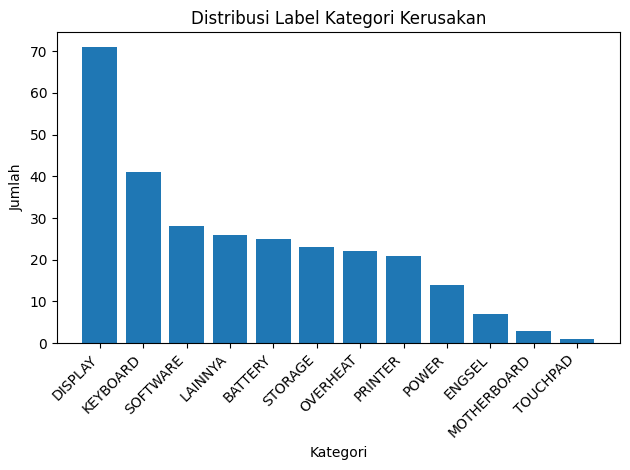

In [15]:

label_counts = df["label_kategori"].value_counts()

plt.figure()
plt.bar(label_counts.index, label_counts.values)
plt.xticks(rotation=45, ha="right")
plt.title("Distribusi Label Kategori Kerusakan")
plt.xlabel("Kategori")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

### 4.2 Grafik 2 — Distribusi Jenis Perangkat

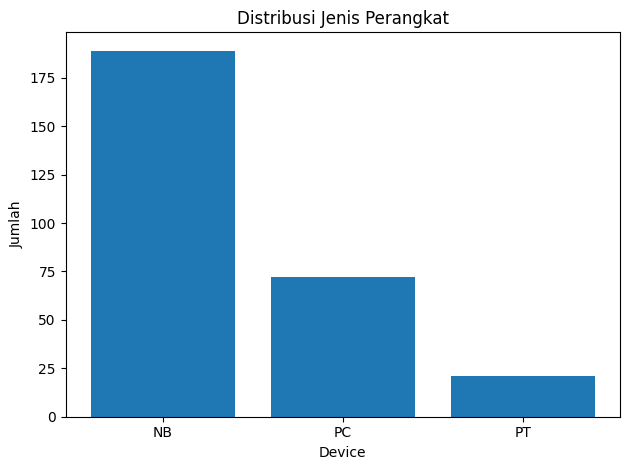

In [16]:

device_counts = df["ttcheck_device_service"].value_counts()

plt.figure()
plt.bar(device_counts.index, device_counts.values)
plt.title("Distribusi Jenis Perangkat")
plt.xlabel("Device")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

### 4.3 Grafik 3 — Top 10 Merk Perangkat

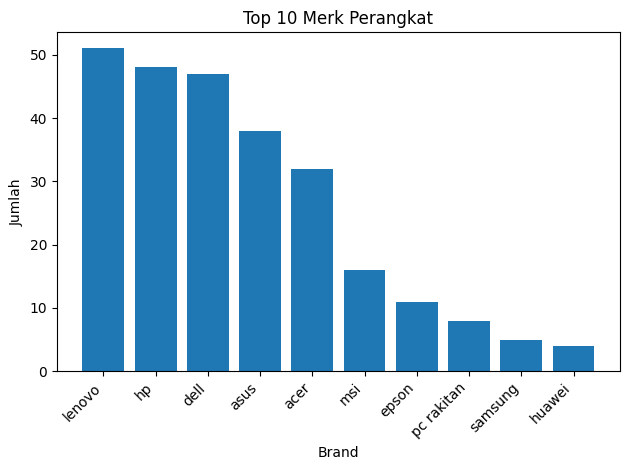

In [17]:

brand_counts = df["ttcheck_brand_service"].value_counts().head(10)

plt.figure()
plt.bar(brand_counts.index, brand_counts.values)
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Merk Perangkat")
plt.xlabel("Brand")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

### 4.4 Grafik 4 — Distribusi Panjang Teks Keluhan

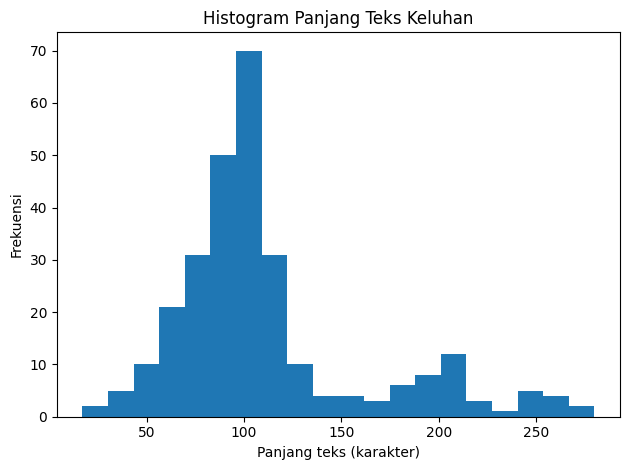

In [18]:

plt.figure()
plt.hist(df["text_len"], bins=20)
plt.title("Histogram Panjang Teks Keluhan")
plt.xlabel("Panjang teks (karakter)")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()

### 4.5 Grafik 5 — Heatmap Crosstab Device vs Label (proporsi)

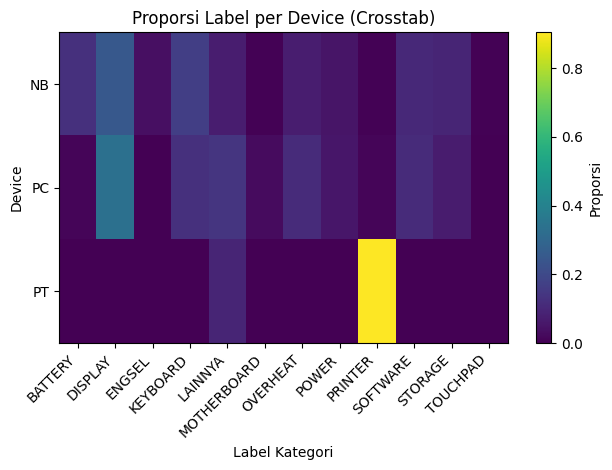

In [19]:

ct = pd.crosstab(df["ttcheck_device_service"], df["label_kategori"], normalize="index")

plt.figure()
plt.imshow(ct.values, aspect="auto")
plt.title("Proporsi Label per Device (Crosstab)")
plt.xlabel("Label Kategori")
plt.ylabel("Device")
plt.xticks(ticks=np.arange(ct.shape[1]), labels=ct.columns, rotation=45, ha="right")
plt.yticks(ticks=np.arange(ct.shape[0]), labels=ct.index)
plt.colorbar(label="Proporsi")
plt.tight_layout()
plt.show()

## 5. Feature Engineering

Pada tahap ini dataset disiapkan untuk masuk ke model:
- Menentukan **X** (fitur) dan **y** (label target).
- Menyatukan fitur teks (`text_combined`) dan fitur kategori (`device`, `brand`, `series`).
- Menangani kategori yang sangat jarang agar fitur one-hot tidak terlalu spesifik.
- Membagi data menjadi **train-test split**.

In [20]:
feature_cols = ["text_combined", "ttcheck_device_service", "ttcheck_brand_service", "ttcheck_series_service"]
target_col = "label_kategori"

# Rare category handling (untuk fitur kategori)
min_freq = 2
for col in ["ttcheck_device_service", "ttcheck_brand_service", "ttcheck_series_service"]:
    vc = df[col].value_counts()
    rare = vc[vc < min_freq].index
    df.loc[df[col].isin(rare), col] = "other"

X = df[feature_cols].copy()
y = df[target_col].copy()

# gabungkan kelas label yang terlalu sedikit
min_label_count = 5  # bisa 2 (biar stratify tidak error) atau 5 (lebih stabil untuk evaluasi)
label_counts = y.value_counts()
rare_labels = label_counts[label_counts < min_label_count].index

print(f"Label dengan jumlah < {min_label_count} akan digabung ke LAINNYA:", list(rare_labels))
y = y.replace({lbl: "LAINNYA" for lbl in rare_labels})

# Baru split stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Distribusi label train:\n", y_train.value_counts())
print("\nDistribusi label test:\n", y_test.value_counts())


Label dengan jumlah < 5 akan digabung ke LAINNYA: ['MOTHERBOARD', 'TOUCHPAD']
Train: (225, 4) Test: (57, 4)
Distribusi label train:
 label_kategori
DISPLAY     57
KEYBOARD    33
LAINNYA     24
SOFTWARE    22
BATTERY     20
STORAGE     18
PRINTER     17
OVERHEAT    17
POWER       11
ENGSEL       6
Name: count, dtype: int64

Distribusi label test:
 label_kategori
DISPLAY     14
KEYBOARD     8
LAINNYA      6
SOFTWARE     6
OVERHEAT     5
STORAGE      5
BATTERY      5
PRINTER      4
POWER        3
ENGSEL       1
Name: count, dtype: int64


## 6. Model Definition

### Baseline DummyClassifier (pembanding minimal)
Baseline digunakan untuk memberi patokan performa minimal.  
`DummyClassifier(strategy="most_frequent")` **selalu menebak kelas yang paling sering muncul** pada data train, tanpa belajar pola fitur.

### Alasan Memilih Decision Tree
Decision Tree dipilih karena:
1. **Interpretabilitas tinggi** (mudah dijelaskan).
2. **Mendukung fitur campuran** (TF-IDF + OneHotEncoding via pipeline).
3. **Cepat untuk inference** (cocok untuk API real-time).
4. Dapat membantu data imbalance dengan `class_weight="balanced"`.

In [21]:

text_feature = "text_combined"
cat_features = ["ttcheck_device_service", "ttcheck_brand_service", "ttcheck_series_service"]

preprocess = ColumnTransformer(
    transformers=[
        ("tfidf", TfidfVectorizer(ngram_range=(1, 2), max_features=5000), text_feature),
        ("ohe", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

baseline_model = DummyClassifier(strategy="most_frequent")

dt_model = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"
)

## 7. Model Training

### 7.1 Baseline (DummyClassifier)

In [22]:

baseline_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", baseline_model)
])

baseline_pipe.fit(X_train, y_train)
y_pred_base = baseline_pipe.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, y_pred_base))
print("Baseline F1-macro:", f1_score(y_test, y_pred_base, average="macro"))

Baseline Accuracy: 0.24561403508771928
Baseline F1-macro: 0.039436619718309855


### 7.2 Decision Tree Default

In [23]:

dt_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", dt_model)
])

dt_pipe.fit(X_train, y_train)
y_pred_dt = dt_pipe.predict(X_test)

print("DT (default) Accuracy:", accuracy_score(y_test, y_pred_dt))
print("DT (default) F1-macro:", f1_score(y_test, y_pred_dt, average="macro"))

DT (default) Accuracy: 0.7368421052631579
DT (default) F1-macro: 0.7477383727383727


### 7.3 Decision Tree Tuning (GridSearchCV)

In [24]:

param_grid = {
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5],
    "model__criterion": ["gini", "entropy"],
}

grid = GridSearchCV(
    estimator=Pipeline(steps=[("preprocess", preprocess), ("model", dt_model)]),
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=0
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best Params:", grid.best_params_)
print("Best CV F1-macro:", grid.best_score_)

y_pred_best = best_model.predict(X_test)
print("Best Model Test Accuracy:", accuracy_score(y_test, y_pred_best))
print("Best Model Test F1-macro:", f1_score(y_test, y_pred_best, average="macro"))



Best Params: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best CV F1-macro: 0.7186366440576967
Best Model Test Accuracy: 0.7017543859649122
Best Model Test F1-macro: 0.7131232560542905


## 8. Model Evaluation

Evaluasi difokuskan pada:
- **Accuracy** & **F1-macro** (utama untuk data tidak seimbang)
- **Nilai per kategori** (precision/recall/f1/support) dalam bentuk tabel
- **Grafik F1-score per kategori**
- **Confusion matrix** untuk melihat pola salah-prediksi
- Visualisasi decision tree (dibatasi depth)

### 8.1 Laporan Evaluasi

In [25]:

def evaluate(y_true, y_pred, title="Model"):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"== {title} ==")
    print("Accuracy :", acc)
    print("F1-macro :", f1m)
    print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))
    return acc, f1m

acc_base, f1_base = evaluate(y_test, y_pred_base, "Baseline (Dummy)")
acc_dt, f1_dt = evaluate(y_test, y_pred_dt, "Decision Tree (Default)")
acc_best, f1_best = evaluate(y_test, y_pred_best, "Decision Tree (Tuned)")



== Baseline (Dummy) ==
Accuracy : 0.24561403508771928
F1-macro : 0.039436619718309855

Classification report:
               precision    recall  f1-score   support

     BATTERY       0.00      0.00      0.00         5
     DISPLAY       0.25      1.00      0.39        14
      ENGSEL       0.00      0.00      0.00         1
    KEYBOARD       0.00      0.00      0.00         8
     LAINNYA       0.00      0.00      0.00         6
    OVERHEAT       0.00      0.00      0.00         5
       POWER       0.00      0.00      0.00         3
     PRINTER       0.00      0.00      0.00         4
    SOFTWARE       0.00      0.00      0.00         6
     STORAGE       0.00      0.00      0.00         5

    accuracy                           0.25        57
   macro avg       0.02      0.10      0.04        57
weighted avg       0.06      0.25      0.10        57

== Decision Tree (Default) ==
Accuracy : 0.7368421052631579
F1-macro : 0.7477383727383727

Classification report:
               p

### 8.2 Tabel Nilai per Kategori (Best Model)

In [26]:

# Ubah classification_report menjadi DataFrame agar mudah dibaca
rep = classification_report(y_test, y_pred_best, output_dict=True, zero_division=0)
rep_df = pd.DataFrame(rep).T

# Ambil hanya baris kelas (buang accuracy/macro/weighted)
kelas = [idx for idx in rep_df.index if idx not in ["accuracy", "macro avg", "weighted avg"]]
rep_kelas = rep_df.loc[kelas, ["precision", "recall", "f1-score", "support"]]

# Urutkan berdasarkan support (jumlah data test per kelas)
rep_kelas = rep_kelas.sort_values("support", ascending=False)

display(rep_kelas)

,precision,recall,f1-score,support
DISPLAY,0.800000,0.857143,0.827586,14.0
KEYBOARD,1.000000,0.625000,0.769231,8.0
SOFTWARE,0.800000,0.666667,0.727273,6.0
LAINNYA,0.250000,0.333333,0.285714,6.0
BATTERY,1.000000,1.000000,1.000000,5.0
OVERHEAT,1.000000,0.400000,0.571429,5.0
STORAGE,0.800000,0.800000,0.800000,5.0
PRINTER,0.750000,0.750000,0.750000,4.0
POWER,0.285714,0.666667,0.400000,3.0
ENGSEL,1.000000,1.000000,1.000000,1.0


### 8.3 Grafik F1-score per Kategori (Best Model)

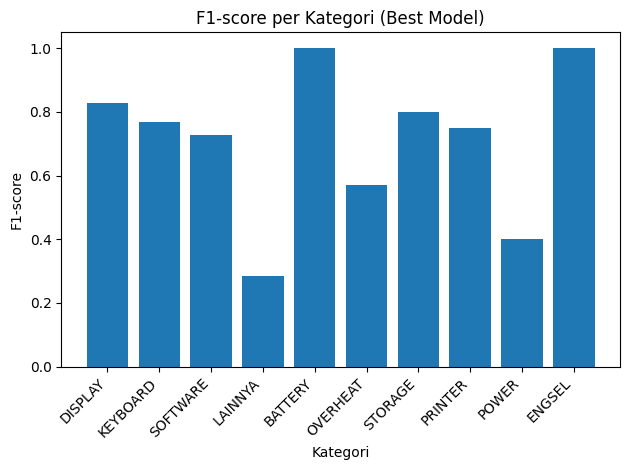

In [27]:

plt.figure()
plt.bar(rep_kelas.index, rep_kelas["f1-score"])
plt.xticks(rotation=45, ha="right")
plt.title("F1-score per Kategori (Best Model)")
plt.xlabel("Kategori")
plt.ylabel("F1-score")
plt.tight_layout()
plt.show()



### 8.4 Confusion Matrix — Best Model

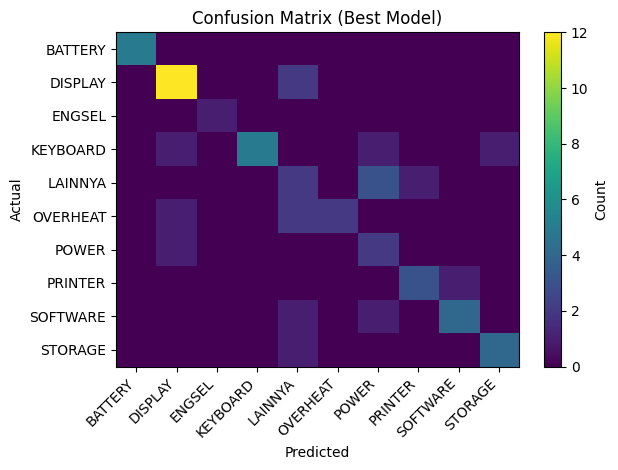

,pred_BATTERY,pred_DISPLAY,pred_ENGSEL,pred_KEYBOARD,pred_LAINNYA,pred_OVERHEAT,pred_POWER,pred_PRINTER,pred_SOFTWARE,pred_STORAGE
actual_BATTERY,5,0,0,0,0,0,0,0,0,0
actual_DISPLAY,0,12,0,0,2,0,0,0,0,0
actual_ENGSEL,0,0,1,0,0,0,0,0,0,0
actual_KEYBOARD,0,1,0,5,0,0,1,0,0,1
actual_LAINNYA,0,0,0,0,2,0,3,1,0,0
actual_OVERHEAT,0,1,0,0,2,2,0,0,0,0
actual_POWER,0,1,0,0,0,0,2,0,0,0
actual_PRINTER,0,0,0,0,0,0,0,3,1,0
actual_SOFTWARE,0,0,0,0,1,0,1,0,4,0
actual_STORAGE,0,0,0,0,1,0,0,0,0,4


In [28]:

labels_sorted = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred_best, labels=labels_sorted)

plt.figure()
plt.imshow(cm, aspect="auto")
plt.title("Confusion Matrix (Best Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=np.arange(len(labels_sorted)), labels=labels_sorted, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(labels_sorted)), labels=labels_sorted)
plt.colorbar(label="Count")
plt.tight_layout()
plt.show()

cm_df = pd.DataFrame(cm, index=[f"actual_{l}" for l in labels_sorted], columns=[f"pred_{l}" for l in labels_sorted])
display(cm_df)

## 9. Model Saving

In [29]:

OUTPUT_DIR = "artifacts"
os.makedirs(OUTPUT_DIR, exist_ok=True)

MODEL_PATH = os.path.join(OUTPUT_DIR, "model_keluhan_decision_tree.joblib")
METRICS_PATH = os.path.join(OUTPUT_DIR, "metrics.json")
CM_PATH = os.path.join(OUTPUT_DIR, "confusion_matrix.csv")
REPORT_PER_CLASS_PATH = os.path.join(OUTPUT_DIR, "report_per_class.csv")

joblib.dump(best_model, MODEL_PATH)

metrics = {
    "baseline": {"accuracy": float(acc_base), "f1_macro": float(f1_base)},
    "dt_default": {"accuracy": float(acc_dt), "f1_macro": float(f1_dt)},
    "dt_tuned": {"accuracy": float(acc_best), "f1_macro": float(f1_best)},
    "best_params": grid.best_params_,
}

with open(METRICS_PATH, "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

cm_df.to_csv(CM_PATH, index=True)
rep_kelas.to_csv(REPORT_PER_CLASS_PATH, index=True)

print("Saved:")
print("-", MODEL_PATH)
print("-", METRICS_PATH)
print("-", CM_PATH)
print("-", REPORT_PER_CLASS_PATH)

Saved:
- artifacts\model_keluhan_decision_tree.joblib
- artifacts\metrics.json
- artifacts\confusion_matrix.csv
- artifacts\report_per_class.csv


## 10. Model Inference (Uji pada Data Baru)

In [30]:

new_samples = pd.DataFrame([
    {
        "text_combined": clean_text("Keyboard tidak berfungsi, udah coba restart tetep tidak bisa"),
        "ttcheck_device_service": "NB",
        "ttcheck_brand_service": "dell",
        "ttcheck_series_service": "dell",
    },
    {
        "text_combined": clean_text("power menyala tetapi display tetap hitam, ada tampilan saat dinyalakan"),
        "ttcheck_device_service": "NB",
        "ttcheck_brand_service": "asus",
        "ttcheck_series_service": "rog",
    },
])

pred = best_model.predict(new_samples)
proba = best_model.predict_proba(new_samples)

result = new_samples.copy()
result["prediksi_kategori"] = pred
result["confidence"] = proba.max(axis=1)

display(result)

,text_combined,ttcheck_device_service,ttcheck_brand_service,ttcheck_series_service,prediksi_kategori,confidence
0,keyboard tidak berfungsi udah coba restart tet...,NB,dell,dell,KEYBOARD,1.0
1,power menyala tetapi display tetap hitam ada t...,NB,asus,rog,DISPLAY,1.0


## 11. Pengambilan Keputusan

**Kesimpulan**:
Model tidak underfit secara umum karena mampu memberikan performa tinggi pada beberapa kategori yang memiliki pola teks spesifik. Namun, performa beberapa kategori (khususnya MOTHERBOARD) masih rendah karena tumpang tindih gejala antar kategori dan kualitas label yang masih bercampur, sehingga generalisasi model untuk kelas tersebut belum optimal.

**Keputusan**:
- Model terbaik disimpan sebagai `artifacts/model_keluhan_decision_tree.joblib`.
- Disimpan juga file pendukung evaluasi: `metrics.json`, `confusion_matrix.csv`, dan `report_per_class.csv`.
- Model siap dipakai API (FastAPI) dengan input: `keluhan`, `device`, `brand`, `series`.

